# Imports

In [1]:
import os
import io
import glob
import shutil
from shutil import copyfile, move
import tempfile
import math
import h5py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
import IPython.display as ipd  # To play sound in the notebook
import soundfile as sf
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, concatenate, RepeatVector, Reshape
from keras.layers import Conv2D, MaxPooling2D, LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling2D, TimeDistributed
from keras.layers import Flatten, Conv1DTranspose
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam, Adamax
from keras.constraints import max_norm

import tensorflow 
from keras.applications import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator

sns.set_style("whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Classes

In [2]:
class ImageDataHandler:
    def __init__(self, data_dir, train_dir='train', val_dir='validation', test_dir='test', image_size=(224, 224)):
        self.data_dir = data_dir
        self.train_dir = os.path.join(data_dir, train_dir)
        self.val_dir = os.path.join(data_dir, val_dir)
        self.test_dir = os.path.join(data_dir, test_dir)
        self.image_size = image_size
        self.emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprised"]

    def filter_images_by_dataset(self, directory, dataset_name):
        filtered_images = [os.path.join(directory, img) for img in os.listdir(directory) if img.startswith(dataset_name) and img.endswith('.png')]
        return filtered_images
    
    def organize_images(self, directory, data_directory, emotions):
        subdir_path = os.path.join(data_directory, directory)
        for emotion in emotions:
            destination_dir = os.path.join(subdir_path, emotion)
            os.makedirs(destination_dir, exist_ok=True)

        # Get a list of all image files in the source directory
        image_files = [f for f in os.listdir(data_directory) if f.endswith('.png')]
        # Move each image to the destination directory
        for image_file in image_files:
            source_path = os.path.join(data_directory, image_file)
            destination_path = os.path.join(subdir_path, image_file)
            shutil.move(source_path, destination_path)

        for image_path in image_files:
            filename = os.path.basename(image_path)
            emotion = filename.split('.')[0].split('_')[-1]
            if emotion in emotions:
                destination_dir = os.path.join(subdir_path, emotion)
                shutil.move(os.path.join(subdir_path, image_path), destination_dir)

    def generators(self, gen_path, BATCH_SIZE, SHUFFLE, COLOR_MODE):

        datagen_type = ImageDataGenerator(rescale=1.0/255.0)
        generator = datagen_type.flow_from_directory(
            gen_path,
            target_size=self.image_size,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=SHUFFLE,
            color_mode=COLOR_MODE,
        )
        return generator

    def create_data_generators(self, dataset_name, BATCH_SIZE=32, SHUFFLE=True, COLOR_MODE='rgb'):

        self.split_images_directories()
        
        if dataset_name == 'all':
            for subdir in [self.train_dir, self.val_dir, self.test_dir]:
                if not os.path.exists(os.path.join(subdir, dataset_name)):
                    for emotion in self.emotions:
                        shutil.move(os.path.join(subdir, emotion), os.path.join(subdir, f'{dataset_name}\\{emotion}'))
            
            train_generator = self.generators(gen_path=os.path.join(self.train_dir, dataset_name), BATCH_SIZE=BATCH_SIZE, SHUFFLE=SHUFFLE, COLOR_MODE=COLOR_MODE)
            val_generator = self.generators(gen_path=os.path.join(self.val_dir, dataset_name), BATCH_SIZE=BATCH_SIZE, SHUFFLE=SHUFFLE, COLOR_MODE=COLOR_MODE)
            test_generator = self.generators(gen_path=os.path.join(self.test_dir, dataset_name), BATCH_SIZE=BATCH_SIZE, SHUFFLE=False, COLOR_MODE=COLOR_MODE)
        
        elif dataset_name in ['ravdess', 'crema', 'tess', 'savee', 'autoencoded_crema']:
            train_filtered_images = self.filter_images_by_dataset(self.train_dir, dataset_name)
            val_filtered_images = self.filter_images_by_dataset(self.val_dir, dataset_name)
            test_filtered_images = self.filter_images_by_dataset(self.test_dir, dataset_name)

            # Create temporary directories and move filtered images to them
            with tempfile.TemporaryDirectory() as temp_train_dir:
                for img in train_filtered_images:
                    shutil.copy(img, temp_train_dir)
                self.organize_images('train', temp_train_dir, self.emotions)

                # Move the data from the temporary directories to the permanent location
                if not os.path.exists(os.path.join(self.train_dir, f'{dataset_name}_train')):
                    shutil.move(os.path.join(temp_train_dir, 'train'), os.path.join(self.train_dir, f'{dataset_name}_train'))
                temp_train_dir = os.path.join(self.train_dir, f'{dataset_name}_train')
                train_generator = self.generators(gen_path=temp_train_dir, BATCH_SIZE=BATCH_SIZE, SHUFFLE=SHUFFLE, COLOR_MODE=COLOR_MODE)

            with tempfile.TemporaryDirectory() as temp_val_dir:
                for img in val_filtered_images:
                    shutil.copy(img, temp_val_dir)
                self.organize_images('validation', temp_val_dir, self.emotions)

                # Move the data from the temporary directories to the permanent location
                if not os.path.exists(os.path.join(self.val_dir, f'{dataset_name}_validation')):
                    shutil.move(os.path.join(temp_val_dir, 'validation'), os.path.join(self.val_dir, f'{dataset_name}_validation'))
                temp_val_dir = os.path.join(self.val_dir, f'{dataset_name}_validation')
                val_generator = self.generators(gen_path=temp_val_dir, BATCH_SIZE=BATCH_SIZE, SHUFFLE=SHUFFLE, COLOR_MODE=COLOR_MODE)

            with tempfile.TemporaryDirectory() as temp_test_dir:
                for img in test_filtered_images:
                    shutil.copy(img, temp_test_dir)
                self.organize_images('test', temp_test_dir, self.emotions)

                # Move the data from the temporary directories to the permanent location
                if not os.path.exists(os.path.join(self.test_dir, f'{dataset_name}_test')):
                    shutil.move(os.path.join(temp_test_dir, 'test'), os.path.join(self.test_dir, f'{dataset_name}_test'))
                temp_test_dir = os.path.join(self.test_dir, f'{dataset_name}_test')
                test_generator = self.generators(gen_path=temp_test_dir, BATCH_SIZE=BATCH_SIZE, SHUFFLE=False, COLOR_MODE=COLOR_MODE)

        else:
            raise ValueError("Invalid dataset_name. Use 'all', 'ravdess', 'crema', 'autoencoded_crema', 'tess' or 'savee'.")
      
        return train_generator, val_generator, test_generator

    def split_images_directories(self, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
        os.makedirs(self.train_dir, exist_ok=True)
        os.makedirs(self.val_dir, exist_ok=True)
        os.makedirs(self.test_dir, exist_ok=True)

        image_files = [f for f in os.listdir(self.data_dir) if f.endswith('.png')]

        random.shuffle(image_files)

        num_train = int(train_ratio * len(image_files))
        num_val = int(val_ratio * len(image_files))

        for file in image_files[:num_train]:
            src = os.path.join(self.data_dir, file)
            dst = os.path.join(self.train_dir, file)
            move(src, dst)

        for file in image_files[num_train:num_train+num_val]:
            src = os.path.join(self.data_dir, file)
            dst = os.path.join(self.val_dir, file)
            move(src, dst)

        for file in image_files[num_train+num_val:]:
            src = os.path.join(self.data_dir, file)
            dst = os.path.join(self.test_dir, file)
            move(src, dst)

In [3]:
class AudioFeatureExtractor:
    def __init__(self, df, frame_length=2048, hop_length=512):
        self.frame_length = frame_length
        self.hop_length = hop_length
        self.df = df

    def features_extraction(self, preprocess=True, trim=True, pad=True, extended=False):
        zcr_list = []
        mfccs_list = []
        emotion_list = []

        if extended:
            rms_list = []
            spectral_centroid_list = []
            spectral_rolloff_list = []
            melspectrogram_list = []
            chroma_stft_list = []
        
        for row in self.df.itertuples(index=False):
            audio, sr = librosa.load(row.audio_path)

            if preprocess:
                audio = self.preprocess_audio(audio, trim, pad)
    
            zcr = librosa.feature.zero_crossing_rate(y=audio, frame_length=self.frame_length, hop_length=self.hop_length)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40, hop_length=self.hop_length)

            zcr_list.append(zcr)
            mfccs_list.append(mfccs)
            emotion_list.append(row.emotions)

            if extended:
                spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, hop_length=self.hop_length)
                spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, hop_length=self.hop_length)
                melspectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, hop_length=self.hop_length)
                chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr, hop_length=self.hop_length)
                rms = librosa.feature.rms(y=audio, frame_length=self.frame_length, hop_length=self.hop_length)
                
                rms_list.append(rms)
                spectral_centroid_list.append(spectral_centroid)
                spectral_rolloff_list.append(spectral_rolloff)
                melspectrogram_list.append(melspectrogram)
                chroma_stft_list.append(chroma_stft)

        if extended:
            return zcr_list, mfccs_list, rms_list, spectral_centroid_list, spectral_rolloff_list, melspectrogram_list, chroma_stft_list, emotion_list
    
        return zcr_list, mfccs_list, emotion_list

    def create_arrays_data(self, preprocess=True):
        zcr_list, mfccs_list, emotion_list = self.features_extraction()

        X = np.concatenate((
            np.swapaxes(zcr_list, 1, 2), 
            np.swapaxes(mfccs_list, 1, 2)), 
            axis=2
        )
        X = X.astype('float32')
        y = np.asarray(emotion_list)
        df = pd.DataFrame({'emotions':emotion_list, 'zcr':zcr_list, 'mfccs': mfccs_list})
            
        return X, y, df
    
    def preprocess_audio(self, audio, trim =True, pad = True, samples_count=120000, silence_db=25):
        if trim:
            audio = self.trim_audio(audio, silence_db)
        if pad:
            audio = self.pad_audio(audio, samples_count)
        return audio

    def trim_audio(self, audio, silence_db):
        trimmed_audio, _ = librosa.effects.trim(audio, top_db=silence_db)
        return trimmed_audio

    def pad_audio(self, audio, samples_count):
        padded_audio = np.pad(audio, (0, samples_count-len(audio)), 'constant')
        return padded_audio

In [4]:
class SpectrogramDataCreator:
    def __init__(self, num_mels=224, width=96, height=64):
        self.num_mels = num_mels
        self.max_length = 0
        self.width = width
        self.height = height

    def create_data(self, df, save_folder):
        X_spectrogram = []
        y = []
        
        os.makedirs(save_folder, exist_ok=True)

        for i, row in df.iterrows():
            audio_path = row['audio_path']
            emotion = row['emotions']
            dataset = row['dataset']
            spectrogram = self._extract_spectrogram(audio_path)
            X_spectrogram.append(spectrogram)
            y.append(emotion)

            # Save the spectrogram as an image
            filename = f"{dataset}_index{i}_{emotion}.png"
            filepath = os.path.join(save_folder, filename)
            self._save_spectrogram_image(spectrogram, filepath)

            # Update maximum length if needed
            if spectrogram.shape[1] > self.max_length:
                self.max_length = spectrogram.shape[1]

        # Apply padding or truncation with the computed maximum length
        for i in range(len(X_spectrogram)):
            if X_spectrogram[i].shape[1] < self.max_length:
                pad_width = self.max_length - X_spectrogram[i].shape[1]
                X_spectrogram[i] = np.pad(X_spectrogram[i], pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                X_spectrogram[i] = X_spectrogram[i][:, :self.max_length]

        X_spectrogram = np.array(X_spectrogram)
        y = np.array(y)

        return X_spectrogram, y, self.max_length

    def _extract_spectrogram(self, audio_path):
        audio, sr = librosa.load(audio_path)
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=self.num_mels)
        return spectrogram

    def _save_spectrogram_image(self, spectrogram, filepath):
        plt.figure(figsize=(self.width / 100, self.height / 100), dpi=100)  # Set the figure size to 96x64
        librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), y_axis='mel', x_axis='time')
        plt.axis('off')  # Remove axis ticks and labels
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove unnecessary margins
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0)  # Save the image without extra padding
        plt.close()

In [5]:
class MFCCDataCreator:
    def __init__(self, num_mfcc=30):
        self.num_mfcc = num_mfcc
        self.max_length = 0

    def create_data(self, df):
        X_mfcc = []
        X_audio = []
        sr_list = []
        y = []

        for i, row in df.iterrows():
            audio_path = row['audio_path']
            emotion = row['emotions']
            mfcc, audio, sr = self._extract_mfcc(audio_path)
            X_mfcc.append(mfcc)
            X_audio.append(audio)
            sr_list.append(sr)

            y.append(emotion)
            # Update maximum length if needed
            if mfcc.shape[1] > self.max_length:
                self.max_length = mfcc.shape[1]

        # Apply padding or truncation with the computed maximum length
        for i in range(len(X_mfcc)):
            if X_mfcc[i].shape[1] < self.max_length:
                pad_width = self.max_length - X_mfcc[i].shape[1]
                X_mfcc[i] = np.pad(X_mfcc[i], pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                X_mfcc[i] = X_mfcc[i][:, :self.max_length]

        X_mfcc = np.array(X_mfcc)
        #X_audio = np.array(X_audio)
        #sr_list = np.array(sr_list)
        y = np.array(y)

        return X_mfcc, y, self.max_length
        #return X_mfcc, X_audio, sr_list, y, self.max_length
    
    # extract_mfcc function is an internal method
    def _extract_mfcc(self, audio_path):
        audio, sr = librosa.load(audio_path)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=self.num_mfcc)
        return mfcc, audio, sr

In [6]:
class DataPreprocessor:
    def __init__(self, X, y, dataframe):
        self.X = X
        self.y = y
        self.dataframe = dataframe
        self.num_classes = len(dataframe['emotions'].unique())
        self.class_labels = list(dataframe['emotions'].unique())
        self.label_encoder = LabelEncoder()
    
    def split_data(self, test_size=0.2, val_size=0.1, random_state=42):
        # This methods splits the arrays after the mfcc extraction
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            self.X, self.y, test_size=test_size, shuffle=True, random_state=random_state)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size, random_state=random_state)
        
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def split_dataframe(self, test_size=0.2, val_size=0.1, random_state=42):
        # Splitting the data into train, val, test datasets
        train_val, test = train_test_split(self.dataframe, test_size=test_size, shuffle=True, random_state=random_state)
        train, val = train_test_split(train_val, test_size=val_size, shuffle=True, random_state=random_state)

        train = train.reset_index(drop=True)
        val = val.reset_index(drop=True)
        test = test.reset_index(drop=True)
        return train, val, test
    
    def normalize_data(self, X_train, X):

        flattened_train = X_train.reshape(-1, X_train.shape[-1])  
        flattened_X = X.reshape(-1, X.shape[-1])

        scaler = StandardScaler()
        scaler.fit(flattened_train)

        X_scaled = scaler.transform(flattened_X)

        X_scaled = X_scaled.reshape(X.shape)

        return X_scaled
    
    def modify_channels(self, X):
        X_modified = X[..., np.newaxis]
        return X_modified
    
    def encode_labels(self, y_train, y_val, y_test):
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        y_val_encoded = self.label_encoder.transform(y_val)
        y_test_encoded = self.label_encoder.transform(y_test)
        return y_train_encoded, y_val_encoded, y_test_encoded
    
    def one_hot_encode_labels(self, y_encoded):
        y_categorical = to_categorical(y_encoded, self.num_classes, dtype='float32')
        return y_categorical
    
    def preprocess_data(self):
        X_train, X_val, X_test, y_train, y_val, y_test = self.split_data()
        X_train_scaled = self.normalize_data(X_train, X_train)
        X_val_scaled = self.normalize_data(X_train, X_val)
        X_test_scaled = self.normalize_data(X_train, X_test)
        X_train_modified = self.modify_channels(X_train_scaled)
        X_val_modified = self.modify_channels(X_val_scaled)
        X_test_modified = self.modify_channels(X_test_scaled)
        y_train_encoded, y_val_encoded, y_test_encoded = self.encode_labels(y_train, y_val, y_test)
        y_train_categorical = self.one_hot_encode_labels(y_train_encoded)
        y_val_categorical = self.one_hot_encode_labels(y_val_encoded)
        y_test_categorical = self.one_hot_encode_labels(y_test_encoded)
        
        return X_train_modified, X_val_modified, X_test_modified, y_train_categorical, y_val_categorical, y_test_categorical, self.num_classes, self.class_labels

In [7]:
class DataAugmentation:
    def __init__(self) -> None:
        pass

    def shift_pitch(self, audio, sr, semitones):
        shifted_audio = librosa.effects.pitch_shift(audio, n_steps=float(semitones), sr=sr)
        return shifted_audio
    
    def time_shift(self, audio, sr, shift_range=5):
        shift_samples = np.random.randint(-shift_range, shift_range)*1000
        shifted_audio = np.roll(audio, shift=shift_samples)
        return shifted_audio
    
    def time_stretch(self, audio, rate):
        stretched_audio = librosa.effects.time_stretch(audio, rate=rate)
        return stretched_audio
    
    def add_noise(self, audio, noise_factor):
        noise = np.random.randn(len(audio))
        noise_factor = noise_factor *np.random.uniform() * np.amax(audio)
        noisy_audio = audio + noise_factor * noise
        return noisy_audio

In [8]:
class EmotionClassifier:
    def __init__(self, model, num_classes, class_labels, dataframe):
        self.model = model
        self.dataframe = dataframe
        self.num_classes = num_classes
        self.class_labels = class_labels
    
    def predict_sample(self, test):

        # Randomly choose a sample from X_test_scaled
        sample_index  = np.random.choice(self.dataframe.shape[0])
        # Get the selected sample
        sample = test[sample_index]

        prediction = self.model.predict(np.expand_dims(sample, axis=0))
        predicted_class = np.argmax(prediction)
        predicted_emotion = self.class_labels[predicted_class]
        
        # Display sample and prediction
        print("Sample Emotion:", self.dataframe.iloc[sample_index].emotions)
        print("Predicted Emotion:", predicted_emotion)
        
        # Display sound 
        audio = ipd.Audio(self.dataframe.iloc[sample_index].audio_path)
        display(audio)
        
    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print("Test Loss:", loss)
        print("Test Accuracy:", accuracy)
        
    def plot_confusion_matrix(self, X_test, y_test, class_labels):
        y_pred = self.model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)

        # Convert y_pred from label-encoded to one-hot encoded format
        y_pred_onehot = to_categorical(y_pred, self.num_classes)

        # Decode y_pred and y_test back to their original class labels
        label_encoder = LabelEncoder()
        label_encoder.fit(class_labels)
        y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred_onehot, axis=1))
        y_test_labels = label_encoder.inverse_transform(np.argmax(y_test, axis=1))
 
        cm = confusion_matrix(y_test_labels, y_pred_labels)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel("Predicted Emotion")
        plt.ylabel("True Emotion")
        plt.title("Confusion Matrix")
        plt.show()

        # Calculate row sums for percentage calculation
        row_sums = cm.sum(axis=1, keepdims=True)

        # Calculate confusion matrix in percentage format
        cm_percentage = (cm / row_sums) * 100

        # Plot the confusion matrix in percentage format
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_percentage, annot=True, fmt=".0f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix (Percentage)")
        plt.show()

    def plot_metrics(self, history):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Functions

In [9]:
def preprocess_audio(audio, samples_count = 120000, silence_db = 25):
    
    trimmed_audio, _ = librosa.effects.trim(audio, top_db=silence_db)
    padded_trimmed_audio = np.pad(trimmed_audio, (0, samples_count-len(trimmed_audio)), 'constant')
    
    return padded_trimmed_audio

In [10]:
def plot_metrics(history, metric):
    train_metric = history.history[metric]
    val_metric = history.history['val_' + metric]
    
    plt.plot(train_metric)
    plt.plot(val_metric)
    plt.title('Model ' + metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [11]:
def create_early_stopping_callback(patience=5,min_delta=0):
    return EarlyStopping(patience=patience, monitor="val_loss", mode='min', verbose=1, min_delta=min_delta)

def create_model_checkpoint_callback(file_name, monitor="val_accuracy"):
    return ModelCheckpoint(file_name, save_best_only=True, monitor=monitor)

def create_reduce_lr_callback(monitor="val_accuracy", patience=5):
    return ReduceLROnPlateau(factor=0.1, patience=patience, monitor=monitor, min_lr=0.000001)

In [12]:
def play_random_audio(dataframe, gender, emotion, intensity, dataset, preprocess=False):
    # Filter the DataFrame based on the given criteria
    filtered_df = dataframe[(dataframe['genders'] == gender) & (dataframe['emotions'] == emotion) & (dataframe['audio_intensity'] == intensity) & (dataframe['dataset'] == dataset)]
    
    # Randomly select an audio file path
    file_path = random.choice(np.array(filtered_df['audio_path']))
    
    # Load the audio file using librosa
    audio, sr = librosa.load(file_path)

    # Applying preprocess
    if preprocess:
        audio = preprocess_audio(audio)
        
    # Display the waveform plot
    plt.figure(figsize=(12, 4))

    # Waveform plot
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f'Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Spectrogram plot
    plt.subplot(1, 2, 2)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    img = librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel frequency')
    plt.colorbar(format='%+2.0f dB')  # A colorbar with dB format

    plt.subplots_adjust(wspace=0.4)  #  Horizontal spacing between subplots
    plt.suptitle(f'Dataset: {dataframe[dataframe["audio_path"]==file_path]["dataset"].values[0]}, Gender: {gender}, Emotion: {emotion}, Intensity: {intensity}', weight='bold', size=16)
    plt.tight_layout()

    # Play the audio
    return ipd.Audio(file_path)

In [13]:
def play_audio(audio, from_path=False, preprocess=False):
    sr = 22050

    # loading the audio from provided path
    if from_path:
        audio, _ = librosa.load(audio)

    # Applying preprocess
    if preprocess:
        audio = preprocess_audio(audio)
        
    # Display the waveform plot
    plt.figure(figsize=(12, 4))

    # Waveform plot
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f'Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Spectrogram plot
    plt.subplot(1, 2, 2)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    img = librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel frequency')
    plt.colorbar(format='%+2.0f dB')  # A colorbar with dB format

    plt.subplots_adjust(wspace=0.4)  #  Horizontal spacing between subplots
    plt.tight_layout()

    # Play the audio
    return ipd.Audio(audio, rate=sr)

In [14]:
def get_white_noise(signal,SNR=10):
    RMS_s=math.sqrt(np.mean(signal**2))
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    noise=np.random.normal(0, RMS_n, signal.shape[0])
    return noise

# Data Collection

In [15]:
RAVDESS = "./data/ravdess-emotional-speech-audio/"
CREMA = "./data/cremad/"
TESS = "./data/toronto-emotional-speech-set-tess/"

## Ravdess dataframe

In [16]:
ravdess_actors_list = os.listdir(RAVDESS)
audio_emotion = []
audio_path = []
audio_gender = []
audio_intensity = []
durations = []

for file in ravdess_actors_list:
    actor = os.listdir(os.path.join(RAVDESS,file))
    for audio in actor:
        list_audio = audio.split('.')[0] # splitting by the '.' into '**-**-**' . 'wav' and grab the first element
        list_audio = list_audio.split('-') # splitting by the dash
        gender_code = int(list_audio[6])
        
        audio_emotion.append(int(list_audio[2])) # the third element describes the emotion class
        audio_gender.append('female' if gender_code & 1 == 0 else 'male') # the sixth element describes the voice gender 
        audio_intensity.append('normal' if int(list_audio[3]) == 1 else 'high')
        audio_path.append(os.path.join(RAVDESS,file,audio))
        
        audio, sr = librosa.load(os.path.join(RAVDESS,file,audio))
        durations.append(librosa.get_duration(y=audio, sr=sr))

ravdess_df = pd.DataFrame({'emotions': audio_emotion, 'genders': audio_gender, 'audio_intensity': audio_intensity, 'audio_path': audio_path, 'duration':durations})

# Mapping the values to emotions
emotion_dict = {
    1: 'neutral',
    2: 'neutral', # originally - - > 'calm'
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprised',
}

# Replace the values in the column with emotions
ravdess_df['emotions'] = ravdess_df['emotions'] .replace(emotion_dict)
ravdess_df['dataset'] = 'ravdess'
ravdess_df.head()

emotions genders audio_intensity  \
0  neutral    male          normal   
1  neutral    male          normal   
2  neutral    male          normal   
3  neutral    male          normal   
4  neutral    male          normal   

                                          audio_path  duration  dataset  
0  ./data/ravdess-emotional-speech-audio/Actor_01...  3.303311  ravdess  
1  ./data/ravdess-emotional-speech-audio/Actor_01...  3.336689  ravdess  
2  ./data/ravdess-emotional-speech-audio/Actor_01...  3.269932  ravdess  
3  ./data/ravdess-emotional-speech-audio/Actor_01...  3.169841  ravdess  
4  ./data/ravdess-emotional-speech-audio/Actor_01...  3.536871  ravdess

## Crema dataframe

In [17]:
crema_list = os.listdir(CREMA)
audio_emotion = []
audio_path = []
audio_intensity = []
gender_list = []
durations = []

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

emotion_dict = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

intensity_dict = {
    'XX' : 'normal',
    'X' : 'normal',
    'LO' : 'low',
    'MD' : 'normal',
    'HI': 'high'
}

for audio in crema_list:
    list_audio = audio.split('.')[0] # splitting by the '.' into '**-**-**' . 'wav' and grab the first element
    list_audio = list_audio.split('_') # splitting by the underline
    audio_emotion.append(list_audio[2])
    audio_intensity.append(list_audio[3])
    audio_path.append(os.path.join(CREMA,audio))
    gender_list.append('female' if list_audio[0] in female_id_list else 'male')
    
    audio, sr = librosa.load(os.path.join(CREMA,audio))
    durations.append(librosa.get_duration(y=audio, sr=sr))
    
crema_df = pd.DataFrame({'emotions': audio_emotion, 'genders': gender_list, 'audio_intensity': audio_intensity, 'audio_path': audio_path, 'duration':durations})
crema_df['emotions'] = crema_df['emotions'].replace(emotion_dict)
crema_df['audio_intensity'] = crema_df['audio_intensity'].replace(intensity_dict)
crema_df['dataset'] = 'crema'
crema_df.head()

emotions genders audio_intensity                         audio_path  \
0    angry    male          normal  ./data/cremad/1001_DFA_ANG_XX.wav   
1  disgust    male          normal  ./data/cremad/1001_DFA_DIS_XX.wav   
2     fear    male          normal  ./data/cremad/1001_DFA_FEA_XX.wav   
3    happy    male          normal  ./data/cremad/1001_DFA_HAP_XX.wav   
4  neutral    male          normal  ./data/cremad/1001_DFA_NEU_XX.wav   

   duration dataset  
0  2.275601   crema  
1  2.335692   crema  
2  2.168844   crema  
3  1.868526   crema  
4  2.035420   crema

## TESS dataframe

In [18]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 
audio_intensity = []
durations = []

emotion_dict = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'ps'     : 'surprised',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        path_list.append(os.path.join(TESS,directory,audio_file))
        gender_list.append('female') # female only dataset
        audio_intensity.append('normal') # normal only dataset
        emotion_list.append(part.split('_')[2])
        
        audio, sr = librosa.load(os.path.join(TESS,directory,audio_file))
        durations.append(librosa.get_duration(y=audio, sr=sr))
            
tess_df = pd.DataFrame({'emotions': emotion_list, 'genders': gender_list, 'audio_intensity': audio_intensity, 'audio_path': path_list, 'duration':durations})
tess_df['emotions'] = tess_df['emotions'].replace(emotion_dict)
tess_df['dataset'] = 'tess'
tess_df.head()

emotions genders audio_intensity  \
0    angry  female          normal   
1    angry  female          normal   
2    angry  female          normal   
3    angry  female          normal   
4    angry  female          normal   

                                          audio_path  duration dataset  
0  ./data/toronto-emotional-speech-set-tess/OAF_a...  1.539048    tess  
1  ./data/toronto-emotional-speech-set-tess/OAF_a...  1.616644    tess  
2  ./data/toronto-emotional-speech-set-tess/OAF_a...  1.542041    tess  
3  ./data/toronto-emotional-speech-set-tess/OAF_a...  1.606893    tess  
4  ./data/toronto-emotional-speech-set-tess/OAF_a...  1.395193    tess

## SAVEE dataframe

## Merging the dataframes

In [20]:
merged_df = pd.concat([ravdess_df, crema_df, tess_df], axis=0)
merged_df.reset_index(inplace=True, drop=True)
merged_df.to_csv('merged_df.csv',index=False)
merged_df

emotions genders audio_intensity  \
0        neutral    male          normal   
1        neutral    male          normal   
2        neutral    male          normal   
3        neutral    male          normal   
4        neutral    male          normal   
...          ...     ...             ...   
12157  surprised    male          normal   
12158  surprised    male          normal   
12159  surprised    male          normal   
12160  surprised    male          normal   
12161  surprised    male          normal   

                                              audio_path  duration  dataset  
0      ./data/ravdess-emotional-speech-audio/Actor_01...  3.303311  ravdess  
1      ./data/ravdess-emotional-speech-audio/Actor_01...  3.336689  ravdess  
2      ./data/ravdess-emotional-speech-audio/Actor_01...  3.269932  ravdess  
3      ./data/ravdess-emotional-speech-audio/Actor_01...  3.169841  ravdess  
4      ./data/ravdess-emotional-speech-audio/Actor_01...  3.536871  ravdess  
...                                                  ...       ...      ...  
12157  ./data/surrey-audiovisual-expressed-emotion-sa...  2.014059    savee  
12158  ./data/surrey-audiovisual-expressed-emotion-sa...  3.904263    savee  
12159  ./data/surrey-audiovisual-expressed-emotion-sa...  3.532381    savee  
12160  ./data/surrey-audiovisual-expressed-emotion-sa...  5.267619    savee  
12161  ./data/surrey-audiovisual-expressed-emotion-sa...  5.856327    savee  

[12162 rows x 6 columns]

# EDA

## Exploring the data

Text(0.5, 1.0, 'Distribution of Emotions')

<Figure size 1000x600 with 0 Axes>

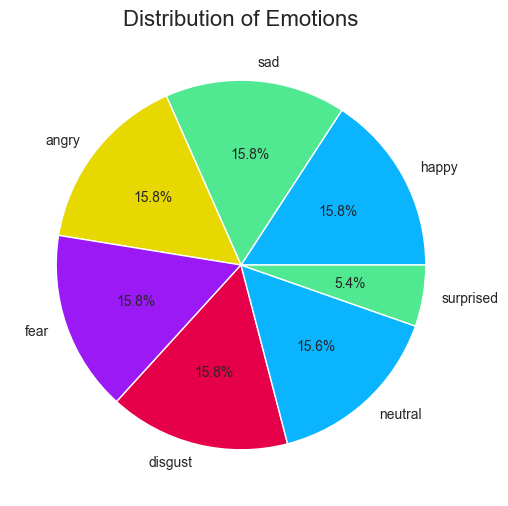

In [21]:
plt.figure(figsize=(10,6))
emotion_percent = merged_df['emotions'].value_counts(normalize=True) * 100

# Set a threshold for small percentage slices
threshold = 5

# Identify emotions below the threshold
small_emotions = emotion_percent[emotion_percent < threshold]

# Create a list of explode values
explode = [0.1 if emotion in small_emotions else 0 for emotion in emotion_percent.index]

# Set the figure size
plt.figure(figsize=(10, 6))

# Define a custom color palette
color_palette = ["#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#e60049"] 

# Create the pie chart with explode values
plt.pie(emotion_percent, labels=emotion_percent.index, autopct='%1.1f%%', colors=color_palette, explode=explode)

# Set the title
plt.title('Distribution of Emotions', size=16)

The pie chart represents the distribution of emotion types in the dataset. <br>
It is evident that apart from the surprised tone with 5.4% , the other types of tones are around 14-16%. <br>
Worth mentioning that the tone 'calm' with its 1.6% distribution in the dataset, was merged with the neutral tone.

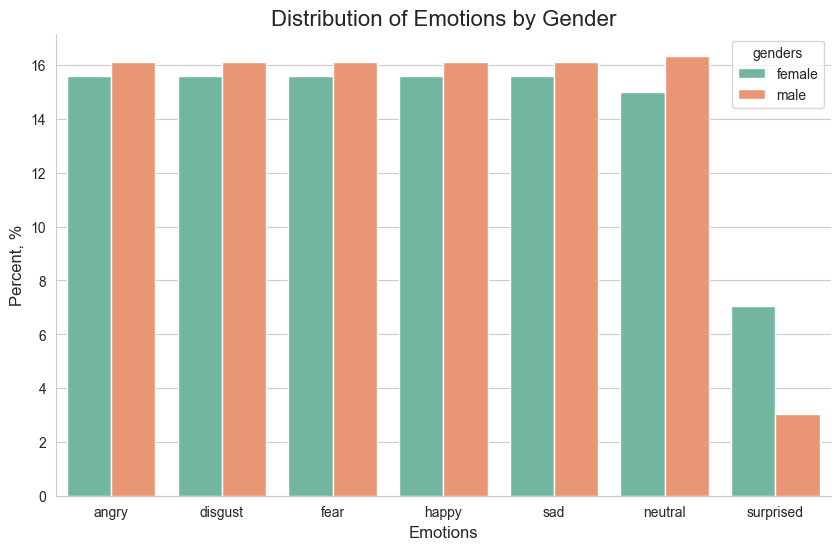

In [22]:
# Calculate the percentage of each emotion by gender
emotions_by_gender = merged_df.groupby('genders')['emotions'].value_counts(normalize=True) * 100

# Reset the index to convert the result into a DataFrame
emotions_by_gender = emotions_by_gender.reset_index(name='percentage')

plt.figure(figsize=(10,6))

sns.barplot(emotions_by_gender, x='emotions', y='percentage', hue='genders', palette='Set2')

plt.title('Distribution of Emotions by Gender', size=16)
plt.xlabel('Emotions', size=12)
plt.ylabel('Percent, %', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine() # Remove the top and right spines

The distribution of emotions in the entire dataset by the gender is relatively uniform.

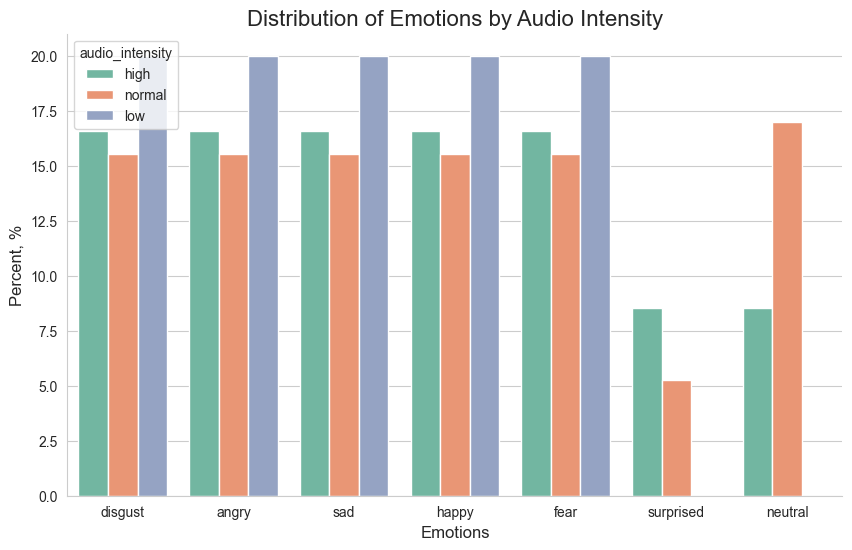

In [23]:
# Calculate the percentage of each emotion by gender
emotions_by_gender = merged_df.groupby('audio_intensity')['emotions'].value_counts(normalize=True) * 100

# Reset the index to convert the result into a DataFrame
emotions_by_gender = emotions_by_gender.reset_index(name='percentage')

plt.figure(figsize=(10,6))

sns.barplot(emotions_by_gender, x='emotions', y='percentage', hue='audio_intensity', hue_order=['high', 'normal', 'low'], palette='Set2')

plt.title('Distribution of Emotions by Audio Intensity', size=16)
plt.xlabel('Emotions', size=12)
plt.ylabel('Percent, %', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine() # Remove the top and right spines

The audio intensity distribution is divided by high, normal, and low. Neutral and surprised tones have only two intensities, normal and high. <br>
The total distribution is uniform between all the modes of the tone intensity (15%-20%), where only in neutral tone there is a higher percentage of normal intensity. 

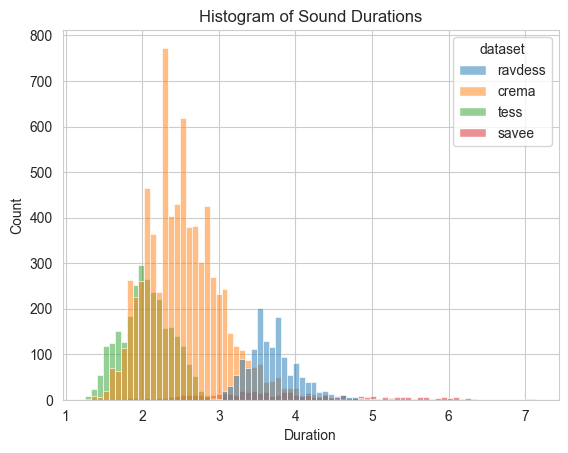

In [24]:
# Create a histogram using seaborn
sns.histplot(data=merged_df, x='duration', hue='dataset')

# Set labels and title
plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('Histogram of Sound Durations')

# Display the histogram
plt.show()

In [25]:
print(f"max input audion duration is {round(merged_df['duration'].max(),2)}")

max input audion duration is 7.14


The audio duration distribution of each dataset is slightly different, with the RAVDESS dataset having the biggest spread.
This means that as part of the data preparation for the model, we'll need to pad the audio files with zeroes based on the longest audio files in the dataset.

## Demonstration of various audio files

Examples of random audio samples

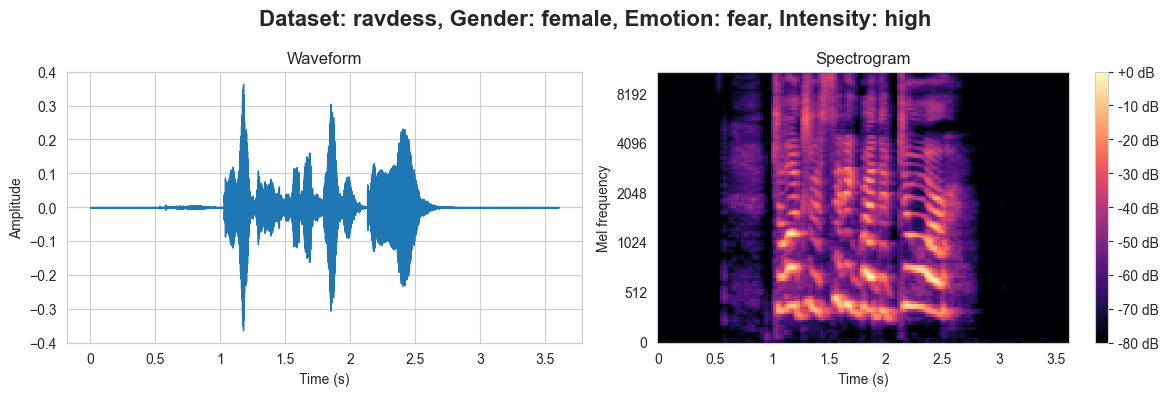

In [26]:
play_random_audio(merged_df, gender="female", emotion="fear", intensity="high", dataset='ravdess')

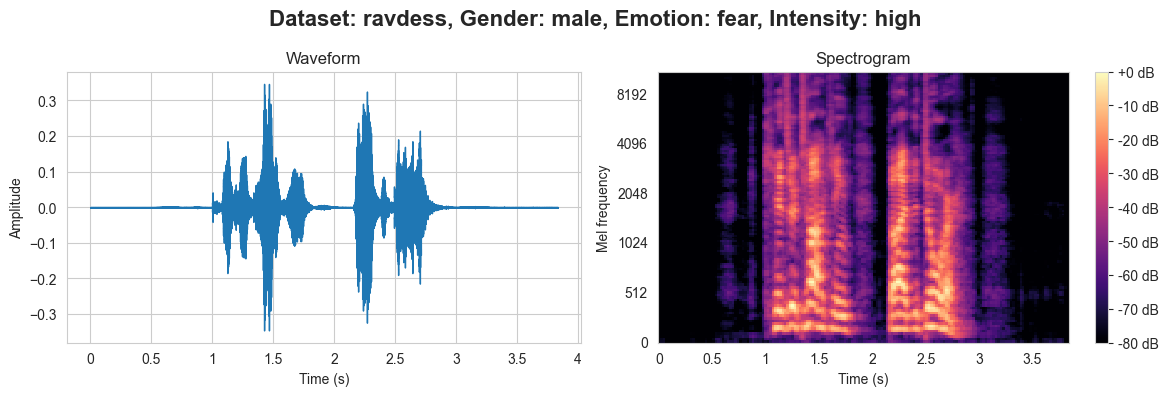

In [27]:
play_random_audio(merged_df, gender="male", emotion="fear", intensity="high", dataset='ravdess')

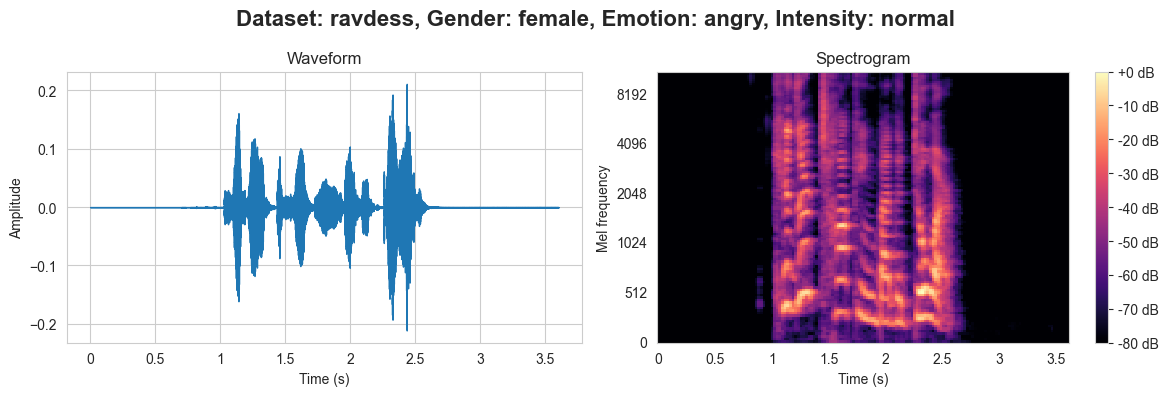

In [30]:
play_random_audio(merged_df, gender="female", emotion="angry", intensity="normal", dataset='ravdess')

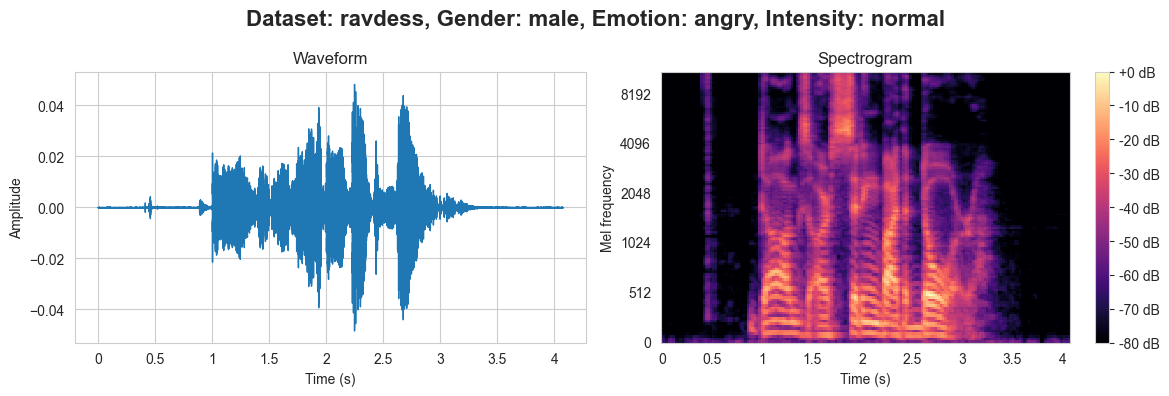

In [31]:
play_random_audio(merged_df, gender="male", emotion="angry", intensity="normal", dataset='ravdess')

Each of the imported datasets originated from a different location, i.e., some with background noise, different sentences, gender of speakers, etc... <br>
This contributes to the quality of the whole data frame and thereafter to the ability of the model to classify an emotion of an unseen dataset. <br>
From the samples above, one can qualitatively distinguish between the various emotions, despite being recorded in different environments (e.g., a studio or with a sort of environmental noise) or if the speaker says a different sentence. <br>

The Mel-frequency spectrogram is designed to better approximate the perception of sound by humans, especially in terms of the frequency resolution. It captures more details in the lower frequencies where human hearing is more sensitive and provides a more perceptually relevant representation compared to the regular spectrogram with a linear frequency scale.








# Feature Extraction & Preprocessing

## Data Preprocessing

Audio preprocess can be used to trim the silence from both side of the audio signal and/or pad the signal to a set maximum value in order to have a consistent input length

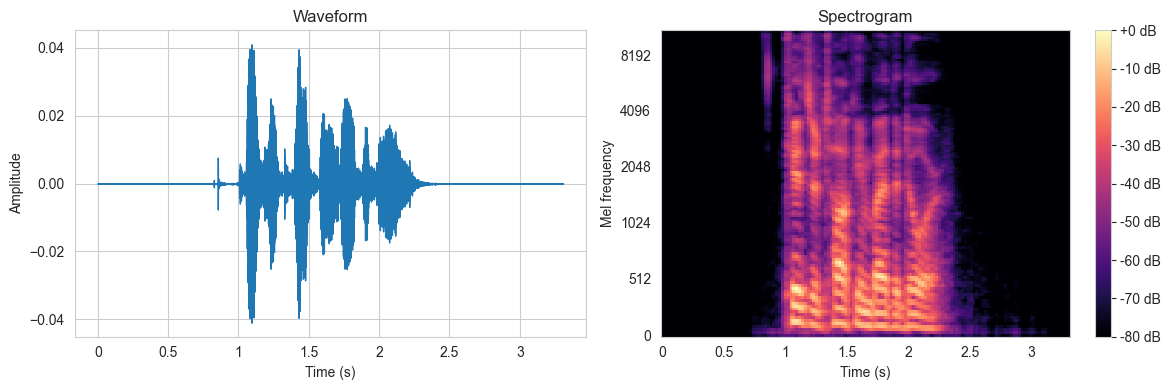

In [32]:
play_audio(merged_df['audio_path'][0], from_path=True)

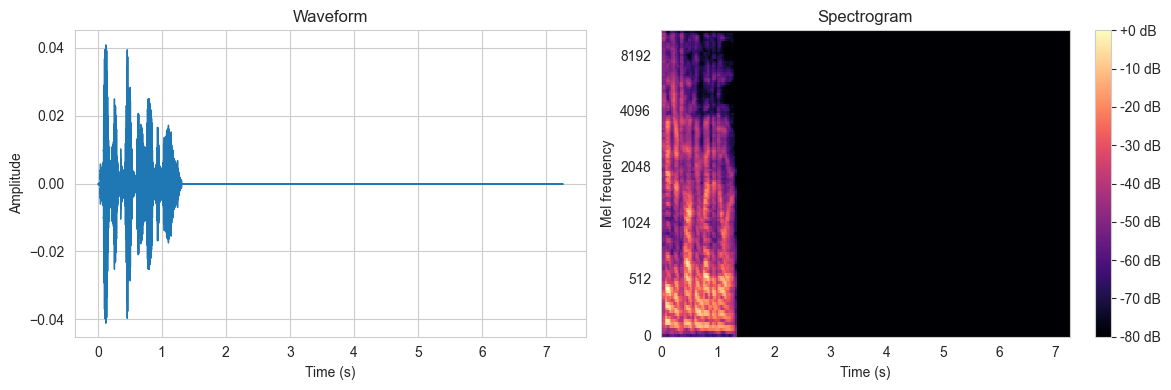

In [33]:
play_audio(merged_df['audio_path'][0], from_path=True, preprocess=True)

## Autoencoding model

### Conv1D Autoencoder

In [34]:
# creating pure and noisy data for model training
noisy_input = []
pure_input = []

pure_audios = []
noisy_audios = []

samples_count = 120000

for i, row in ravdess_df.iterrows():
    audio, sr = librosa.load(row['audio_path'])
    
    audio = preprocess_audio(audio, samples_count)  
    noisy_audio = audio+get_white_noise(audio)
    
    norm_audio = (audio - np.min(audio)) / (np.max(audio) - np.min(audio))
    norm_noisy_audio = (noisy_audio - np.min(noisy_audio)) / (np.max(noisy_audio) - np.min(noisy_audio))
    
    pure_input.append(norm_audio)
    noisy_input.append(norm_noisy_audio)
    pure_audios.append(audio)
    noisy_audios.append(noisy_audio)

noisy_input = np.array(noisy_input)
pure_input = np.array(pure_input)

noisy_input = noisy_input.reshape((noisy_input.shape[0], noisy_input.shape[1], 1))
pure_input = pure_input.reshape((pure_input.shape[0], pure_input.shape[1], 1))

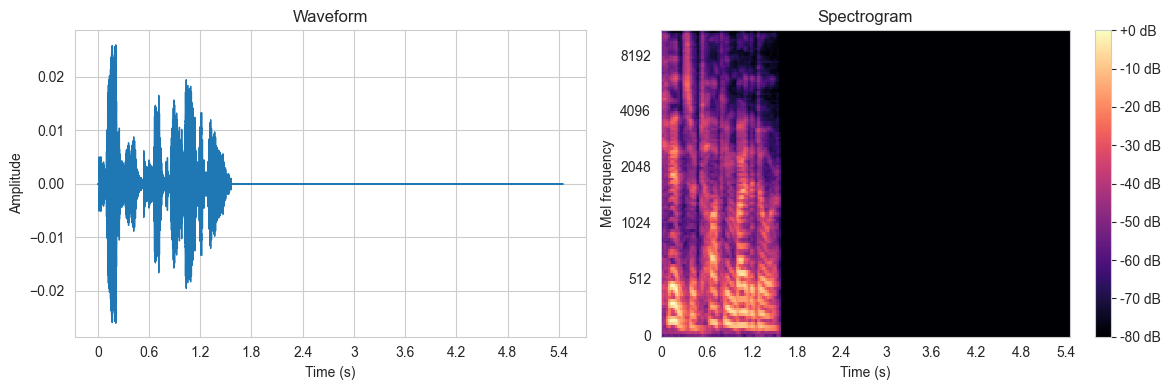

In [35]:
play_audio(pure_audios[4])

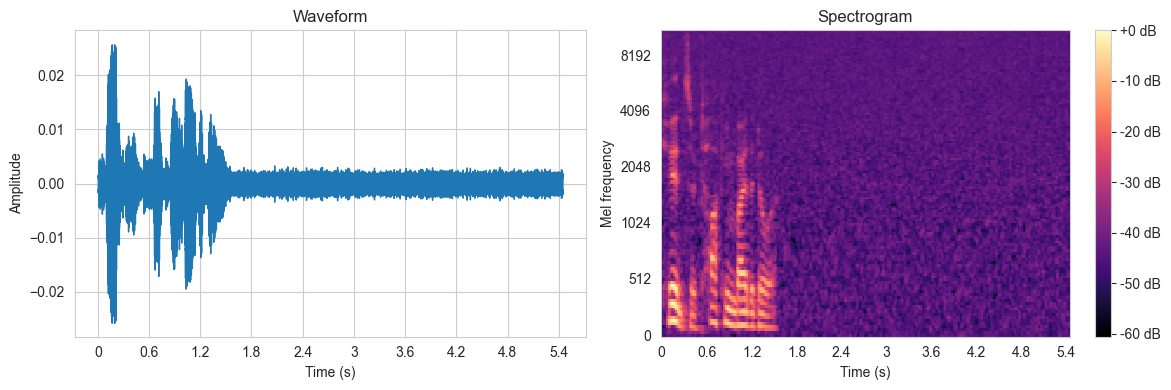

In [36]:
play_audio(noisy_audios[4])

In [37]:
autoencoder = load_model('best_autoencoder_plus.h5')

In [38]:
prediction = autoencoder.predict(noisy_input[:5])

1/1 [==============================] - 1s 1s/step


In [39]:
prediction = np.squeeze(prediction)

In [40]:
autoencoded_sound = (prediction[4] * (np.max(noisy_audios[4]) - np.min(noisy_audios[4]))) + np.min(noisy_audios[4])

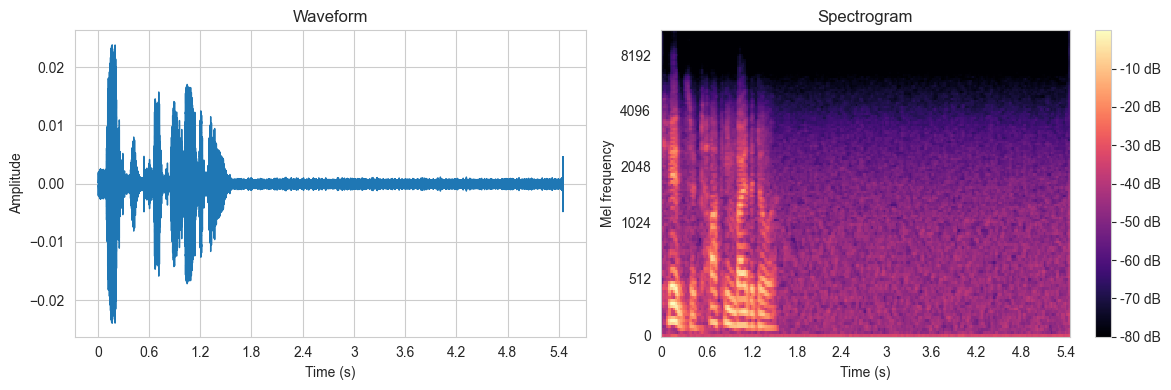

In [41]:
play_audio(autoencoded_sound)

### Autoencoding Crema dataset

In [42]:
# creating pure and noisy data for model training
noisy_input = []
noisy_audios = []
paths = []

samples_count = 120000

for i, row in crema_df.iterrows():
    noisy_audio, sr = librosa.load(row['audio_path'])

    noisy_audio = preprocess_audio(noisy_audio, samples_count)  

    norm_noisy_audio = (noisy_audio - np.min(noisy_audio)) / (np.max(noisy_audio) - np.min(noisy_audio))
    
    noisy_input.append(norm_noisy_audio)
    noisy_audios.append(noisy_audio)

    paths.append(row['audio_path'])

noisy_input = np.array(noisy_input)

noisy_input = noisy_input.reshape((noisy_input.shape[0], noisy_input.shape[1], 1))

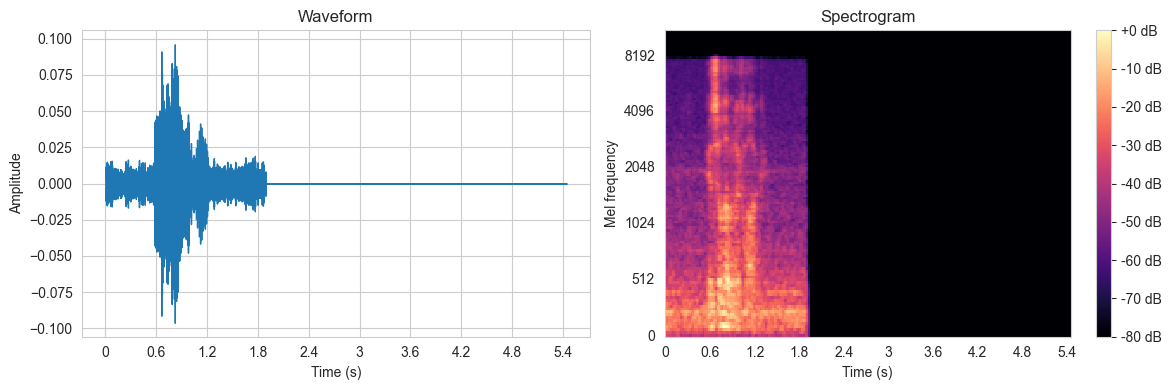

In [43]:
play_audio(noisy_audios[20])

In [44]:
prediction = autoencoder.predict(noisy_input[:30])

1/1 [==============================] - 5s 5s/step


In [45]:
prediction = np.squeeze(prediction)

In [46]:
autoencoded_sound = (prediction[20] * (np.max(noisy_audios[20]) - np.min(noisy_audios[20]))) + np.min(noisy_audios[20])

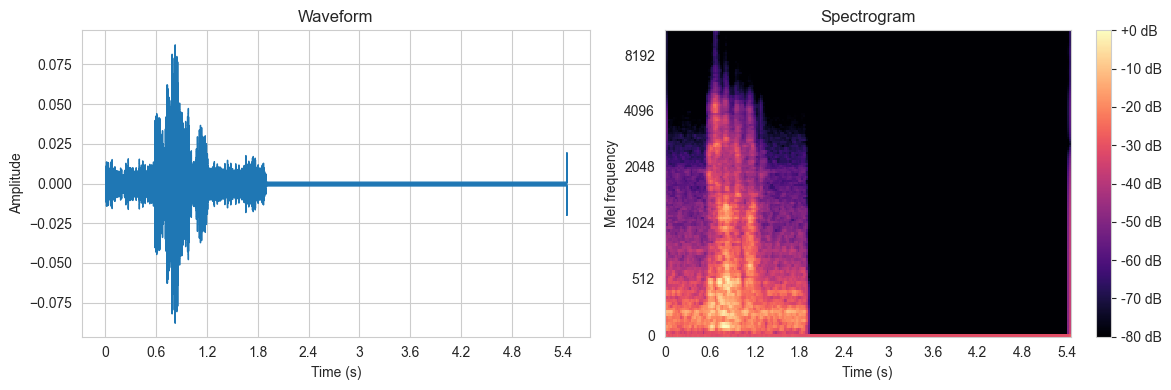

In [47]:
play_audio(autoencoded_sound)

In [48]:
AUTOENCODED_CREMA = "./data/autoencoded_cremad/"

In [49]:
crema_list = os.listdir(AUTOENCODED_CREMA)
audio_emotion = []
audio_path = []
audio_intensity = []
gender_list = []
durations = []

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

emotion_dict = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

intensity_dict = {
    'XX' : 'normal',
    'X' : 'normal',
    'LO' : 'low',
    'MD' : 'normal',
    'HI': 'high'
}

for audio in crema_list:
    list_audio = audio.split('.')[0] # splitting by the '.' into '**-**-**' . 'wav' and grab the first element
    list_audio = list_audio.split('_') # splitting by the underline
    audio_emotion.append(list_audio[2])
    audio_intensity.append(list_audio[3])
    audio_path.append(os.path.join(AUTOENCODED_CREMA,audio))
    gender_list.append('female' if list_audio[0] in female_id_list else 'male')
    
    audio, sr = librosa.load(os.path.join(AUTOENCODED_CREMA,audio))
    durations.append(librosa.get_duration(y=audio, sr=sr))
    
autoencoded_crema_df = pd.DataFrame({'emotions': audio_emotion, 'genders': gender_list, 'audio_intensity': audio_intensity, 'audio_path': audio_path, 'duration':durations})
autoencoded_crema_df['emotions'] = autoencoded_crema_df['emotions'].replace(emotion_dict)
autoencoded_crema_df['audio_intensity'] = autoencoded_crema_df['audio_intensity'].replace(intensity_dict)
autoencoded_crema_df['dataset'] = 'autoencoded_crema'
autoencoded_crema_df.head()

emotions genders audio_intensity  \
0    angry    male          normal   
1  disgust    male          normal   
2     fear    male          normal   
3    happy    male          normal   
4  neutral    male          normal   

                                      audio_path  duration            dataset  
0  ./data/autoencoded_cremad/1001_DFA_ANG_XX.wav  5.442177  autoencoded_crema  
1  ./data/autoencoded_cremad/1001_DFA_DIS_XX.wav  5.442177  autoencoded_crema  
2  ./data/autoencoded_cremad/1001_DFA_FEA_XX.wav  5.442177  autoencoded_crema  
3  ./data/autoencoded_cremad/1001_DFA_HAP_XX.wav  5.442177  autoencoded_crema  
4  ./data/autoencoded_cremad/1001_DFA_NEU_XX.wav  5.442177  autoencoded_crema

In [50]:
autoencoded_crema_df.to_csv('autoencoded_cremad.csv',index=False)

# Baseline model

## 2D Convolution on MFCC images

In [74]:
class MFCCModelConv2D:
    def __init__(self, df, kernel_size, model_name, num_mfcc=40, patience=5, epochs=50):
        self.df = df
        self.kernel_size = kernel_size
        self.model_name = model_name
        self.num_mfcc = num_mfcc
        self.data_creator = None
        self.preprocessor = None
        self.model = None
        self.num_classes = None
        self.class_labels = None
        self.history = None
        self.X_train_scaled = None
        self.X_val_scaled = None
        self.X_test_scaled = None
        self.y_train_categorical = None
        self.y_val_categorical = None
        self.y_test_categorical = None
        self.patience = patience
        self.epochs = epochs

    def create_data_and_preprocess(self):
        self.data_creator = MFCCDataCreator(num_mfcc=self.num_mfcc)
        X_mfcc, y, max_length = self.data_creator.create_data(self.df)

        self.preprocessor = DataPreprocessor(X_mfcc, y, self.df)
        self.X_train_scaled, self.X_val_scaled, self.X_test_scaled, self.y_train_categorical, self.y_val_categorical, self.y_test_categorical, self.num_classes, self.class_labels = self.preprocessor.preprocess_data()

    def create_model(self):
        optimizer = Adam(learning_rate=0.001)

        input_shape = self.X_train_scaled.shape[1:]
        inputs = Input(shape=input_shape)

        x = Conv2D(32, kernel_size=self.kernel_size, activation="relu", padding="same")(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.2)(x)

        x = Conv2D(32, kernel_size=self.kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.2)(x)

        x = Conv2D(64, kernel_size=self.kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.2)(x)

        x = Conv2D(64, kernel_size=self.kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.2)(x)

        x = Flatten()(x)
        x = Dense(128, activation="relu")(x)
        x = Dropout(0.2)(x)
        outputs = Dense(self.num_classes, activation="softmax")(x)

        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
        self.model.summary()

    def train_model(self):
        callbacks = [
            create_early_stopping_callback(patience=self.patience),
            create_model_checkpoint_callback(f"best_model_{self.model_name}.h5"),
            create_reduce_lr_callback(patience=self.patience)
        ]

        self.history = self.model.fit(self.X_train_scaled, 
                                 self.y_train_categorical, 
                                 batch_size=32, 
                                 epochs=self.epochs, 
                                 validation_data=(self.X_val_scaled, self.y_val_categorical),
                                 callbacks=callbacks
                                )

    def evaluate_model(self):
        emotion_classifier = EmotionClassifier(self.model, self.num_classes, self.class_labels, self.df)
        emotion_classifier.plot_metrics(self.history)
        emotion_classifier.evaluate(self.X_test_scaled, self.y_test_categorical)
        emotion_classifier.plot_confusion_matrix(self.X_test_scaled, self.y_test_categorical, self.class_labels)
        
    def run_all(self):
        print(f'====== creating and preprocessing data for {self.model_name} model ======')
        self.create_data_and_preprocess()
        print(f'\n====== creating model {self.model_name} ======')
        self.create_model()
        print(f'\n====== training model {self.model_name} ======')
        self.train_model()
        print(f'\n====== evaluating model {self.model_name} ======')
        self.evaluate_model()

### 3x3 kernel model

In [75]:
mfcc_3by3_base_model = MFCCModelConv2D(merged_df, (3, 3), 'mfcc_3x3_base', 30)

====== creating and preprocessing data for mfcc_3x3_base model ======

====== creating model mfcc_3x3_base ======
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30, 308, 1)]      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 308, 32)       320       
                                                                 
 batch_normalization_12 (Ba  (None, 30, 308, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 15, 154, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 15, 154, 32)       0         
           

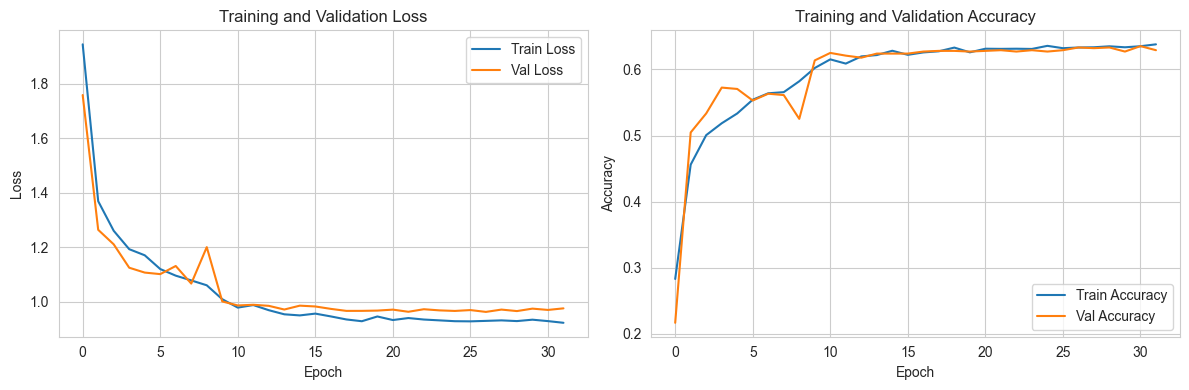

77/77 [==============================] - 4s 53ms/step - loss: 0.9526 - accuracy: 0.6252
Test Loss: 0.952552318572998
Test Accuracy: 0.6251541376113892
77/77 [==============================] - 4s 51ms/step


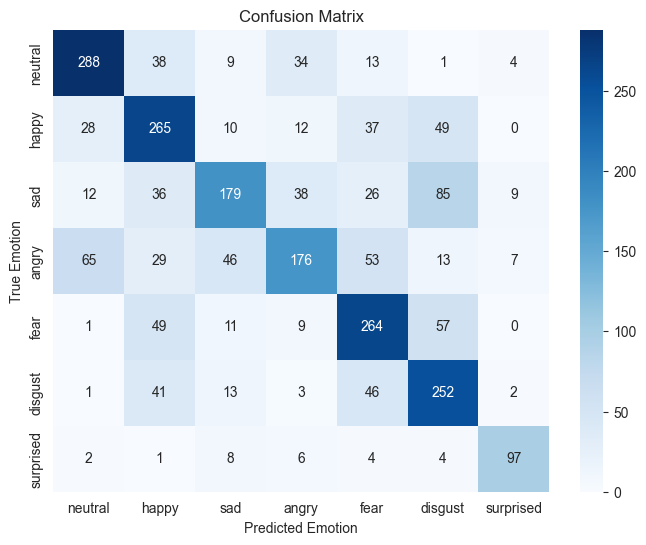

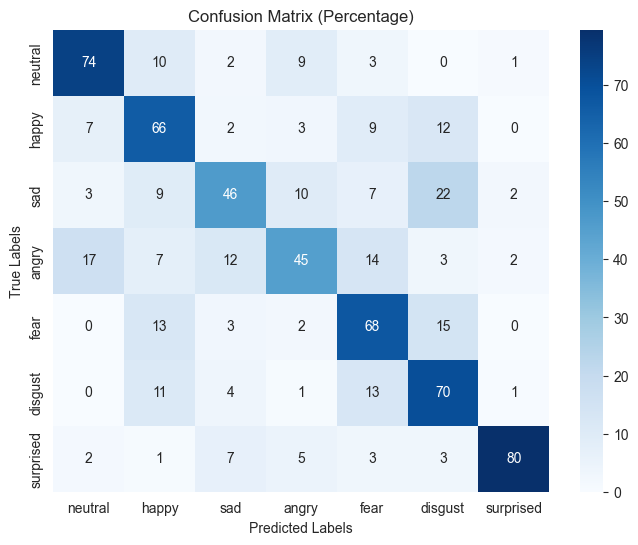

In [76]:
mfcc_3by3_base_model.run_all()

### 4x10 kernel model

Since the MFCC shape is of a wide rectangle, a rectangular kernel might be more fitted for our model Conv2D

====== creating and preprocessing data for mfcc_4x10_base model ======

====== creating model mfcc_4x10_base ======
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 30, 308, 1)]      0         
                                                                 
 conv2d_20 (Conv2D)          (None, 30, 308, 32)       1312      
                                                                 
 batch_normalization_20 (Ba  (None, 30, 308, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 15, 154, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_25 (Dropout)        (None, 15, 154, 32)       0         
         

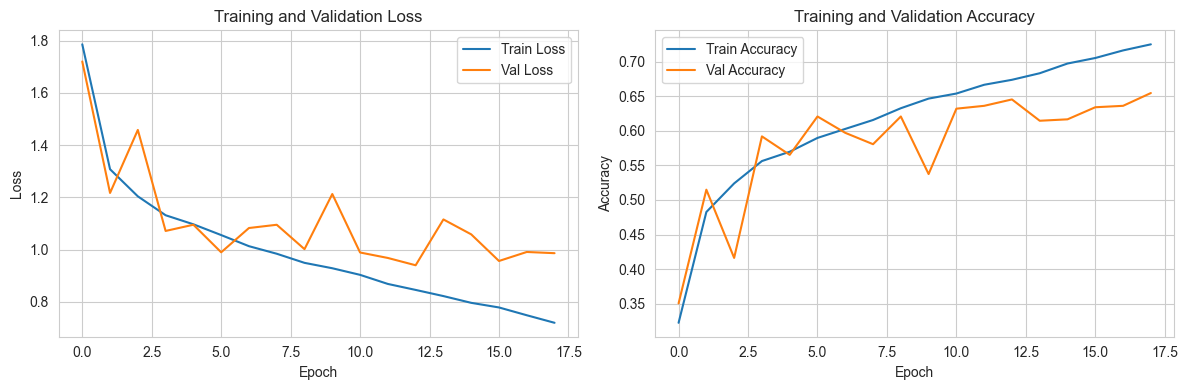

77/77 [==============================] - 6s 81ms/step - loss: 0.9797 - accuracy: 0.6465
Test Loss: 0.9797487854957581
Test Accuracy: 0.6465269327163696
77/77 [==============================] - 6s 81ms/step


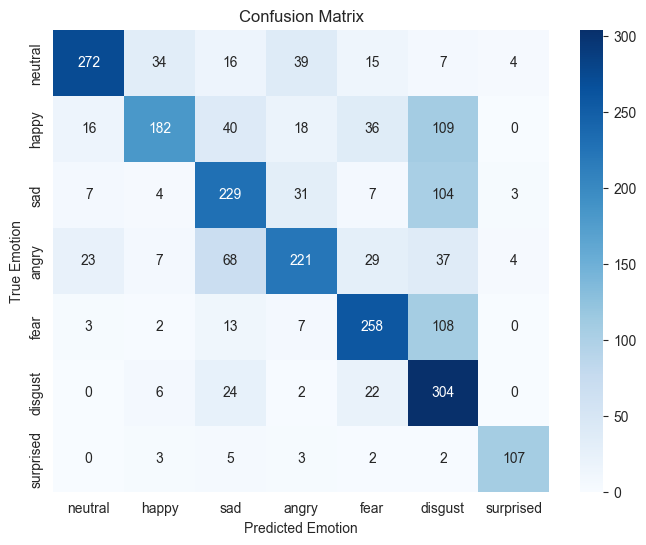

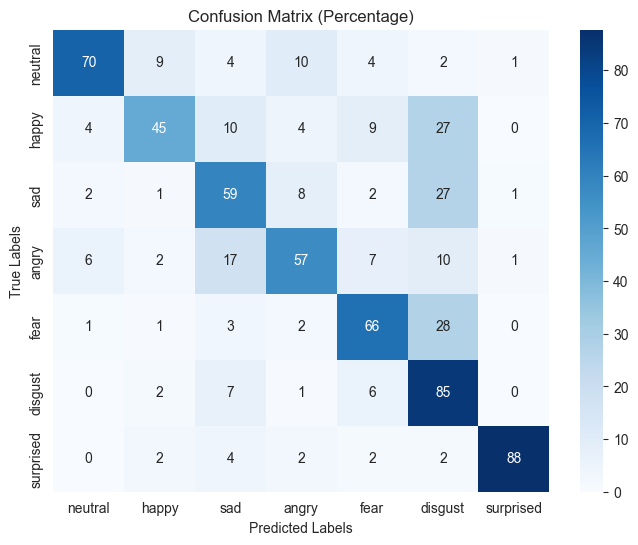

In [78]:
mfcc_4by10_base_model = MFCCModelConv2D(merged_df, (4, 10), 'mfcc_4x10_base', 30)
mfcc_4by10_base_model.run_all()

# Data Augmentation

In [79]:
merged_df = pd.read_csv('merged_df.csv')
augmented_df = pd.read_csv('augmented_df.csv')

In [80]:
final_data = pd.concat([merged_df, augmented_df], axis=0)

In [81]:
final_data_male = final_data[final_data['genders']=='male']
final_data_female = final_data[final_data['genders']=='female']

## 3x3 kernel male model

In [88]:
mfcc_3by3_augmented_model_male = MFCCModelConv2D(final_data_male, (3,3), 'male_kernel3by3_augmented', patience=20, epochs=100)

====== creating and preprocessing data for male_kernel3by3_augmented_male model ======

====== creating model male_kernel3by3_augmented_male ======
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 40, 308, 1)]      0         
                                                                 
 conv2d_32 (Conv2D)          (None, 40, 308, 32)       320       
                                                                 
 batch_normalization_32 (Ba  (None, 40, 308, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 20, 154, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_40 (Dropout)        (None, 20, 154

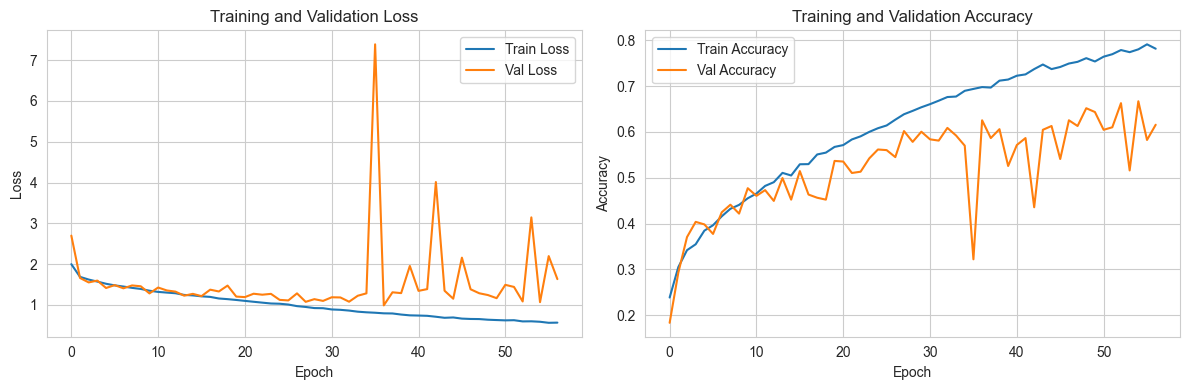

57/57 [==============================] - 4s 76ms/step - loss: 1.5303 - accuracy: 0.6217
Test Loss: 1.530336618423462
Test Accuracy: 0.621741533279419
57/57 [==============================] - 4s 71ms/step


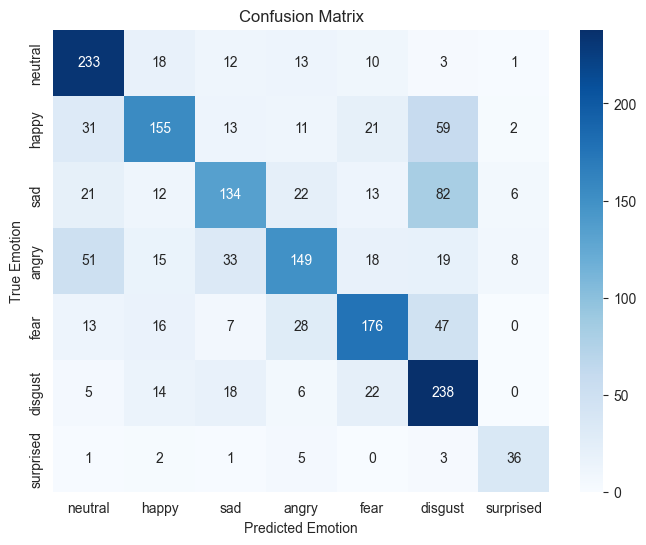

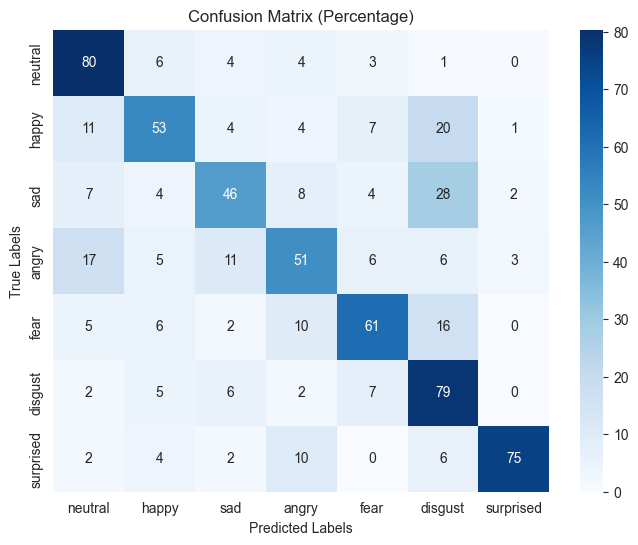

In [89]:
mfcc_3by3_augmented_model_male.run_all()

## 3x3 kernel female model

In [92]:
mfcc_3by3_augmented_model_female = MFCCModelConv2D(final_data_female, (3,3), 'female_kernel3by3_augmented', patience=20, epochs=100)

====== creating and preprocessing data for female_kernel3by3_augmented model ======

====== creating model female_kernel3by3_augmented ======
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 40, 220, 1)]      0         
                                                                 
 conv2d_40 (Conv2D)          (None, 40, 220, 32)       320       
                                                                 
 batch_normalization_40 (Ba  (None, 40, 220, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 20, 110, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_50 (Dropout)        (None, 20, 110, 32)

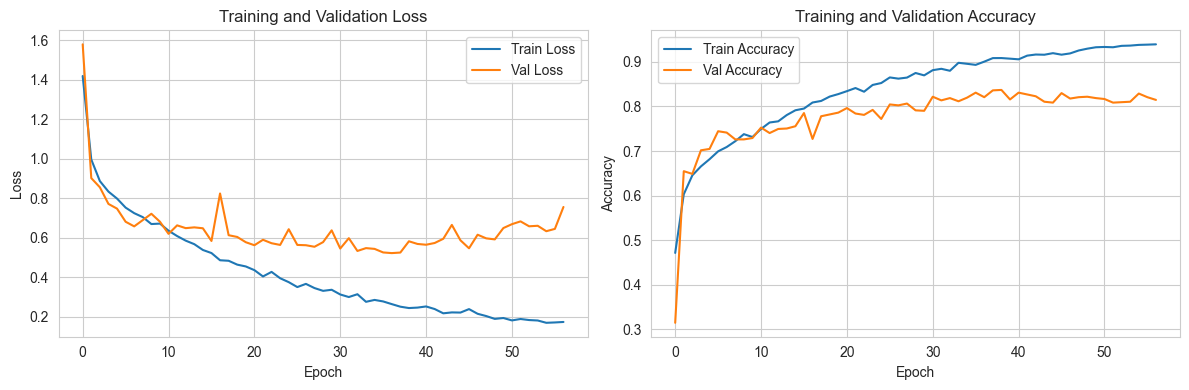

77/77 [==============================] - 4s 56ms/step - loss: 0.6708 - accuracy: 0.8354
Test Loss: 0.6708145141601562
Test Accuracy: 0.8354378938674927
77/77 [==============================] - 4s 56ms/step


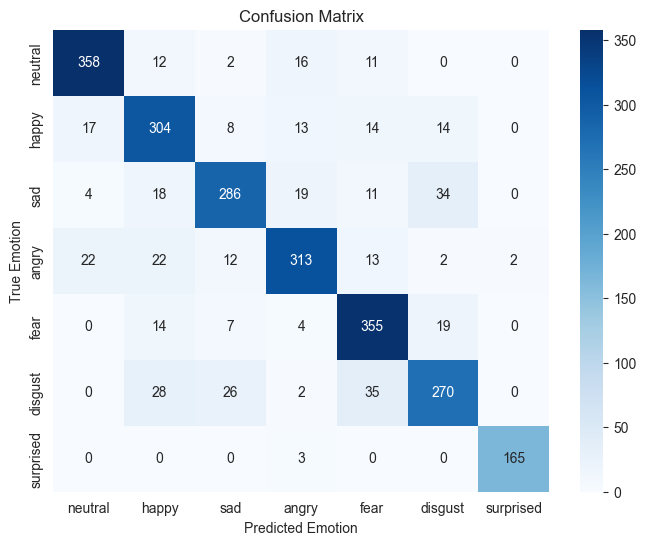

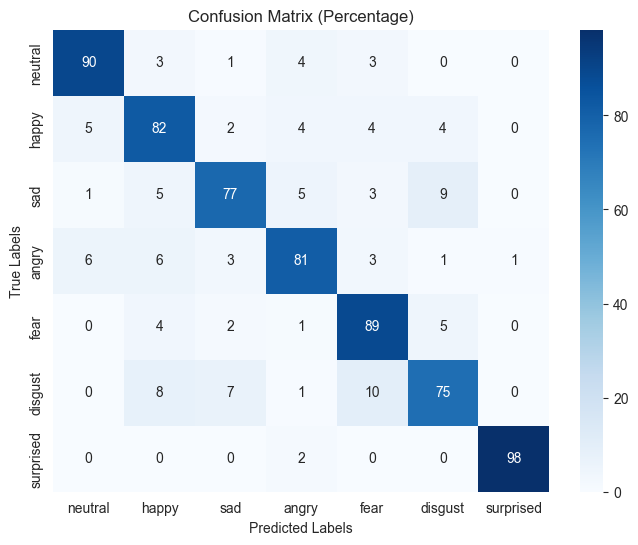

In [93]:
mfcc_3by3_augmented_model_female.run_all()

## 4x10 kernel male model

In [94]:
mfcc_4by10_augmented_model_male = MFCCModelConv2D(final_data_male, (4,10), 'male_kernel4by10_augmented', patience=20, epochs=100)

====== creating and preprocessing data for male_kernel4by10_augmented model ======

====== creating model male_kernel4by10_augmented ======
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 40, 308, 1)]      0         
                                                                 
 conv2d_44 (Conv2D)          (None, 40, 308, 32)       1312      
                                                                 
 batch_normalization_44 (Ba  (None, 40, 308, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 20, 154, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_55 (Dropout)        (None, 20, 154, 32)  

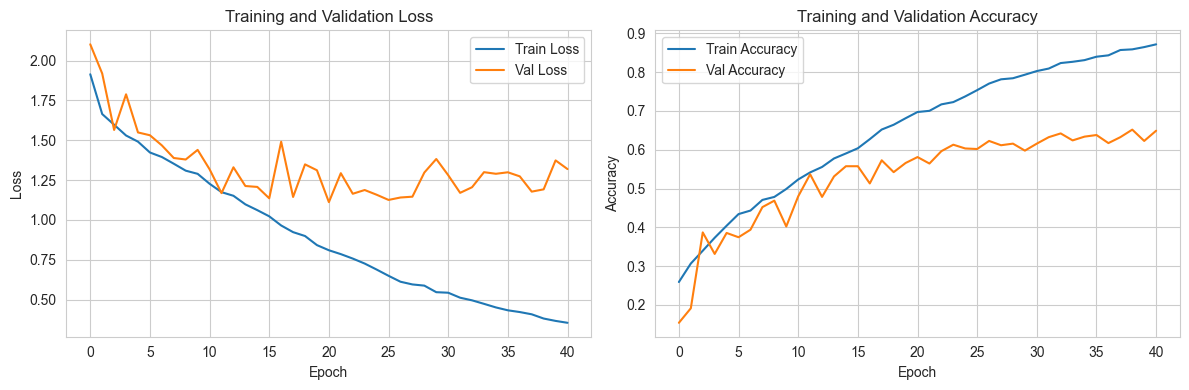

57/57 [==============================] - 6s 112ms/step - loss: 1.1510 - accuracy: 0.6628
Test Loss: 1.1510052680969238
Test Accuracy: 0.662784218788147
57/57 [==============================] - 7s 113ms/step


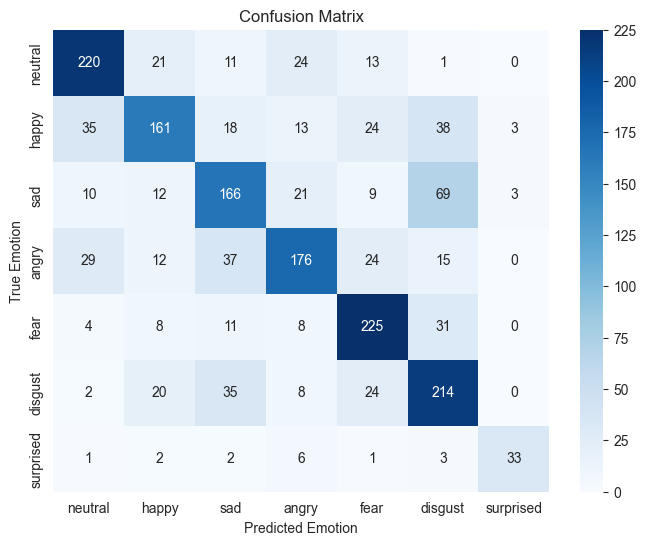

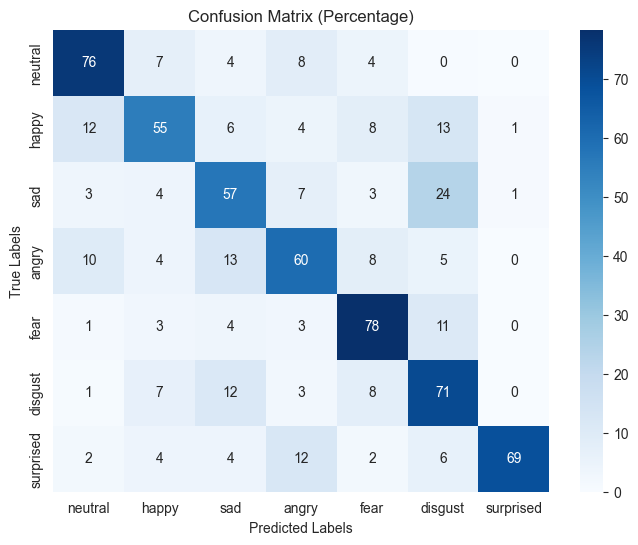

In [95]:
mfcc_4by10_augmented_model_male.run_all()

## 4x10 kernel female model

In [96]:
mfcc_4by10_augmented_model_female = MFCCModelConv2D(final_data_female, (4,10), 'female_kernel4by10_augmented', patience=20, epochs=100)

In [97]:
mfcc_4by10_augmented_model_female.run_all()

====== creating and preprocessing data for female_kernel4by10_augmented model ======

====== creating model female_kernel4by10_augmented ======
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 40, 220, 1)]      0         
                                                                 
 conv2d_48 (Conv2D)          (None, 40, 220, 32)       1312      
                                                                 
 batch_normalization_48 (Ba  (None, 40, 220, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 20, 110, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_60 (Dropout)        (None, 20, 110, 3

KeyboardInterrupt: 

# LSTM features Model

In [108]:
merged_df = pd.read_csv('merged_df.csv')
augmented_df = pd.read_csv('augmented_df.csv')
autoencoded_df = pd.read_csv('autoencoded_cremad.csv')

In [109]:
final_data_autoencoded = pd.concat([merged_df, augmented_df, autoencoded_df], axis=0)

In [110]:
final_data_autoencoded = final_data_autoencoded[final_data_autoencoded['dataset']!='crema']

In [111]:
final_data_autoencoded_male = final_data_autoencoded[final_data_autoencoded['genders']=='male']
final_data_autoencoded_female = final_data_autoencoded[final_data_autoencoded['genders']=='female']

In [112]:
class LSTMModel:
    def __init__(self, df, model_name, patience=20, epochs=100):
        self.df = df
        self.model_name = model_name
        self.patience = patience
        self.epochs = epochs
        self.history = None

    def prepare_data(self):
        feature_extractor = AudioFeatureExtractor(self.df)
        X, y, df = feature_extractor.create_arrays_data()
        X = X.reshape(X.shape[0], X.shape[2], -1)

        preprocessor = DataPreprocessor(X, y, df)
        X_train_scaled, X_val_scaled, X_test_scaled, y_train_categorical, y_val_categorical, y_test_categorical, num_classes, class_labels = preprocessor.preprocess_data()

        self.X_train_scaled = X_train_scaled
        self.X_val_scaled = X_val_scaled
        self.X_test_scaled = X_test_scaled
        self.y_train_categorical = y_train_categorical
        self.y_val_categorical = y_val_categorical
        self.y_test_categorical = y_test_categorical
        self.num_classes = num_classes
        self.class_labels = class_labels

    def build_model(self):
        model = Sequential()
        model.add(LSTM(256, return_sequences=True, input_shape=(self.X_train_scaled.shape[1:3])))
        model.add(Dropout(0.2))
        model.add(LSTM(64))
        model.add(Dropout(0.2))
        model.add(Dense(64))
        model.add(Dropout(0.2))
        model.add(Dense(7, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01), metrics=['accuracy'])
        self.model.summary()

        self.model = model

    def train_model(self):
        callbacks = [
            create_early_stopping_callback(patience=self.patience),
            create_model_checkpoint_callback(f'best_model_lstm_{self.model_name}.h5'),
            create_reduce_lr_callback(patience=self.patience)
        ]

        history = self.model.fit(self.X_train_scaled,
                                 self.y_train_categorical,
                                 batch_size=10,
                                 epochs=self.epochs,
                                 validation_data=(self.X_val_scaled, self.y_val_categorical),
                                 callbacks=callbacks
                                 )

        self.history = history

    def evaluate_model(self):
        self.emotion_classifier = EmotionClassifier(self.model, self.num_classes, self.class_labels, self.df)
        self.emotion_classifier.plot_metrics(self.history)
        self.emotion_classifier.evaluate(self.X_test_scaled, self.y_test_categorical)
        self.emotion_classifier.plot_confusion_matrix(self.X_test_scaled, self.y_test_categorical, self.class_labels)

    def run_all(self):
        print(f'====== creating and preprocessing data for {self.model_name} model ======')
        self.prepare_data()
        print(f'\n====== creating model {self.model_name} ======')
        self.build_model()
        print(f'\n====== training model {self.model_name} ======')
        self.train_model()
        print(f'\n====== evaluating model {self.model_name} ======')
        self.evaluate_model()

## Augmented and autoencoded male model

In [ ]:
male_lstm_model = LSTMModel(final_data_autoencoded_male, 'male_augmented_autoencoded')
male_lstm_model.run_all()

## Augmented and autoencoded male model

====== creating and preprocessing data for female_augmented_autoencoded model ======

====== creating model female_augmented_autoencoded ======

====== training model female_augmented_autoencoded ======
Epoch 1/100
693/693 [==============================] - 33s 45ms/step - loss: 1.8343 - accuracy: 0.2296 - val_loss: 1.7586 - val_accuracy: 0.2727 - lr: 0.0100
Epoch 2/100
693/693 [==============================] - 31s 45ms/step - loss: 1.6231 - accuracy: 0.2833 - val_loss: 1.5159 - val_accuracy: 0.3403 - lr: 0.0100
Epoch 3/100
693/693 [==============================] - 32s 46ms/step - loss: 1.4583 - accuracy: 0.3597 - val_loss: 1.3245 - val_accuracy: 0.4143 - lr: 0.0100
Epoch 4/100
693/693 [==============================] - 32s 46ms/step - loss: 1.2294 - accuracy: 0.4827 - val_loss: 1.0243 - val_accuracy: 0.5649 - lr: 0.0100
Epoch 5/100
693/693 [==============================] - 32s 46ms/step - loss: 1.0247 - accuracy: 0.5870 - val_loss: 0.8777 - val_accuracy: 0.6455 - lr: 0.0100
Epoch 6

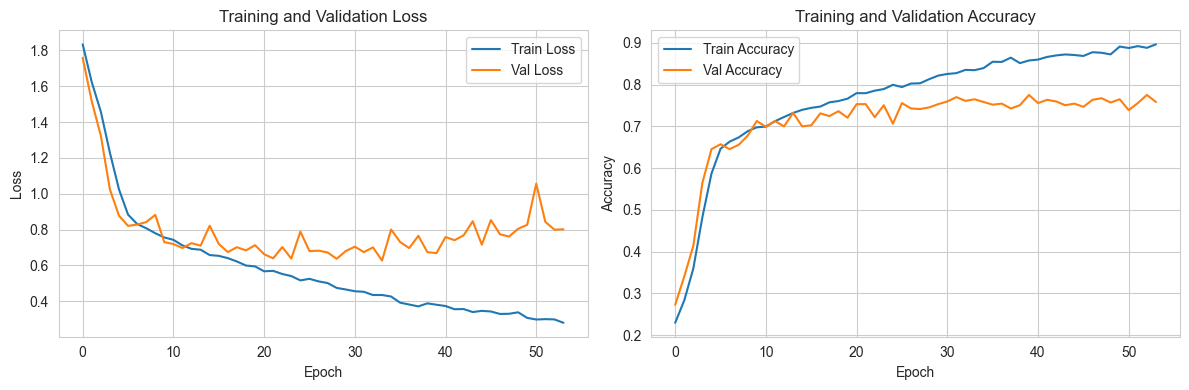

61/61 [==============================] - 3s 32ms/step - loss: 0.8342 - accuracy: 0.7804
Test Loss: 0.8341615200042725
Test Accuracy: 0.7803738117218018
61/61 [==============================] - 2s 30ms/step


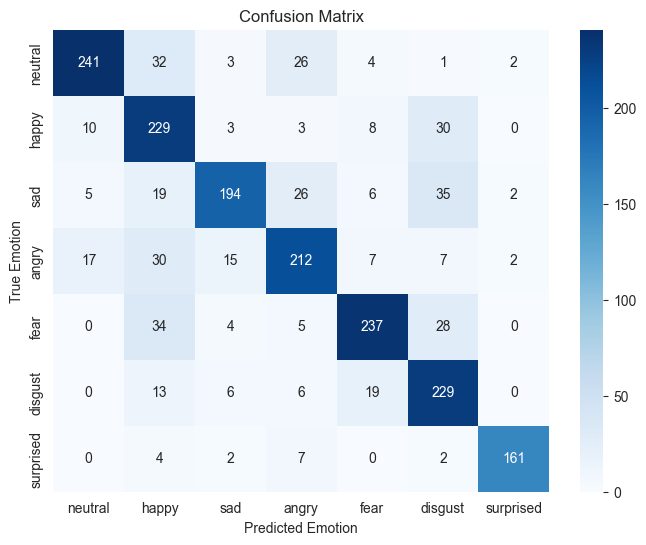

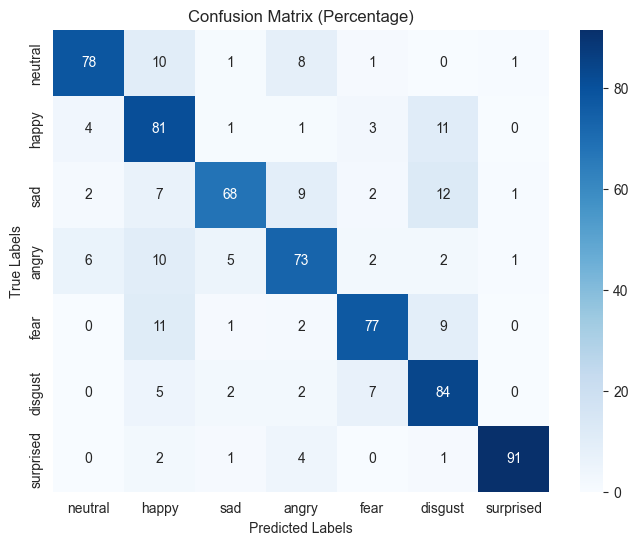

In [113]:
female_lstm_model = LSTMModel(final_data_autoencoded_female, 'female_augmented_autoencoded')
female_lstm_model.run_all()

# MobileNetV2 transfer learning

## Generating mel-spectogram images

In [114]:
merged_df = pd.read_csv('merged_df.csv')
augmented_df = pd.read_csv('augmented_df.csv')
autoencoded_df = pd.read_csv('autoencoded_cremad.csv')

In [115]:
final_data_autoencoded = pd.concat([merged_df, augmented_df, autoencoded_df], axis=0)

In [116]:
final_data_autoencoded = final_data_autoencoded[final_data_autoencoded['dataset']!='crema']

In [120]:
# required dimensions for MobileNetV2
width=224
height=224

#for gender in final_data_autoencoded['genders'].unique():
for gender in ['female']:    
    gender_df = final_data_autoencoded[final_data_autoencoded['genders']==gender].reset_index(drop=True)
    data_directory = f'spectrogram_images_{width}x{height}_{gender}'
    spectrogram_data_creator = SpectrogramDataCreator(width=width, height=height)
    X_spectrogram, y, max_length = spectrogram_data_creator.create_data(gender_df, save_folder=data_directory)

In [121]:
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprised"]

## MobileNetV2 male model

In [125]:
class MobileNetV2Model:
    def __init__(self, gender, classes, width=224, height=224, dataset='all', patience=10, epochs=50):
        self.gender = gender
        self.classes = classes
        self.width = width
        self.height = height
        self.dataset = dataset
        self.patience = patience
        self.epochs = epochs
        self.train_generator = None
        self.val_generator = None
        self.test_generator = None

    def create_generators(self):
        data_directory = f'spectrogram_images_{self.width}x{self.height}_{self.gender}'
        handler = ImageDataHandler(data_dir=data_directory, image_size=(self.width, self.height))
        self.train_generator, self.val_generator, self.test_generator = handler.create_data_generators(self.dataset, BATCH_SIZE=64, SHUFFLE=True, COLOR_MODE='rgb')

    def create_model(self):
        input_shape = (self.width, self.height, 3)
        num_classes = len(self.classes)

        base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

        for layer in base_model.layers:
            layer.trainable = False

        x = base_model.output
        x = Flatten()(x)
        x = Dense(1024, activation='relu')(x)
        x = Dropout(0.4)(x)
        outputs = Dense(num_classes, activation='softmax')(x)
        
        model = Model(inputs=base_model.input, outputs=outputs)

        return model

    def train_model(self, model):
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        callbacks = [
            EarlyStopping(patience=self.patience),
            ModelCheckpoint(f'best_model_{self.gender}_mobilenetv2.h5'),
            ReduceLROnPlateau(patience=self.patience)
        ]

        history = model.fit(
            self.train_generator,
            validation_data=self.val_generator,
            batch_size=32,
            callbacks=callbacks,
            epochs=self.epochs,
            shuffle=True
        )

        return history

    def evaluate_model(self, model):
        loss, accuracy = model.evaluate(self.test_generator)
        print("Test Loss:", loss)
        print("Test Accuracy:", accuracy)

    def plot_results(self, history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, '-', label='Training Accuracy')
        plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()

        predictions = model.predict(self.test_generator)
        y_predicted = np.argmax(predictions, axis=1)
        true_labels = test_generator.classes

        mat = confusion_matrix(true_labels, y_predicted)

        emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprised"]
        
        sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
                xticklabels=emotions,
                yticklabels=emotions)
        
        plt.xlabel('Predicted label')
        plt.ylabel('Actual label')
        plt.show()

    def run_all_methods(self):
        print(f'====== creating mobilenetv2 {self.gender} image generators ======')
        self.create_generators()
        print(f'\n====== creating model mobilenetv2 {self.gender} ======')
        model = self.create_model()
        print(f'\n====== training model mobilenetv2 {self.gender} ======')
        history = self.train_model(model)
        print(f'\n====== evaluating model mobilenetv2 {self.gender} ======')
        self.plot_results(history)
        self.evaluate_model(model)

In [ ]:
male_mobilenetv2_model = MobileNetV2Model('male', classes)
male_mobilenetv2_model.run_all_methods()

## MobileNetV2 female model

In [126]:
female_mobilenetv2_model = MobileNetV2Model('female', classes)
female_mobilenetv2_model.run_all_methods()


====== creating mobilenetv2 female image generators ======


FileNotFoundError: [Errno 2] No such file or directory: 'spectrogram_images_224x224_female\\train\\angry'

# Concatenated Model

In [ ]:
file_path = 'best_model_kernel4by10_augmentation.h5'
with h5py.File(file_path, 'r') as file:
    mfcc_model = load_model(file)

file_path = 'transferLearning_mobilenet_melspec.h5'
with h5py.File(file_path, 'r') as file:
    mel_model = load_model(file)

file_path = 'best_model_lstm64_augumentation.h5'
with h5py.File(file_path, 'r') as file:
    audio_model = load_model(file)

In [ ]:
# Update the layer names in the models to make them unique
for layer in mfcc_model.layers:
    layer.name = 'mfcc' + layer.name

for layer in mel_model.layers:
    layer.name = 'mel' + layer.name

for layer in audio_model.layers:
    layer.name = 'audio' + layer.name

In [ ]:
num_classes=7 # should be already in the code (hard coded for this purpose)

In [ ]:
# Get the outputs of the intermediate layers of each model
mfcc_output = mfcc_model.layers[-1].output
mel_output = mel_model.layers[-1].output
audio_output = audio_model.layers[-1].output

# Apply Global Average Pooling to bring outputs to a fixed size
mfcc_output = Reshape((-1, 1))(mfcc_output)
mel_output = Reshape((-1, 1))(mel_output)
audio_output = Reshape((-1, 1))(audio_output)

# Apply Global Average Pooling to bring outputs to a fixed size
mfcc_output = GlobalAveragePooling1D()(mfcc_output)
mel_output = GlobalAveragePooling1D()(mel_output)
audio_output = GlobalAveragePooling1D()(audio_output)

# Add Dense layers to adjust the output sizes to a common size
mfcc_output = Dense(64, activation='relu')(mfcc_output)
mel_output = Dense(64, activation='relu')(mel_output)
audio_output = Dense(64, activation='relu')(audio_output)

# Concatenate the outputs of the intermediate layers
concatenated = concatenate([mfcc_output, mel_output, audio_output])

# Add some additional layers after concatenation
x = Dense(128, activation='relu')(concatenated)
dropout1 = Dropout(0.5, name='dropout_1')(x)  # Specify unique name 'dropout_1'
x = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(0.5, name='dropout_2')(x)  # Specify unique name 'dropout_2'

# Add the final output layer for emotion classification
output = Dense(num_classes, activation='softmax')(dropout2)

# Create the concatenated model
concatenated_model = Model(inputs=[mfcc_model.input, mel_model.input, audio_model.input], outputs=output)

# Freeze the weights of the pre-trained models
mfcc_model.trainable = False
mel_model.trainable = False
audio_model.trainable = False

# Compile the concatenated model
concatenated_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
concatenated_model.summary()

In [ ]:
# Concatenate the labels
y_train = np.concatenate([y_train_mfcc, y_train_mel, y_train_audio], axis=1)

# Train the concatenated model
history = concatenated_model.fit(
    [X_train_mfcc, X_train_mel, X_train_audio],  # Input data for each sub-model
    y_train,  # Concatenated labels for the concatenated model
    batch_size=32,
    epochs=10,
    validation_split=0.2  # If we have a validation set, we can specify it here by the validation_data=() 
    callbacks=callbacks
)

In [ ]:
# Concatenate the test data
X_test_mfcc = np.concatenate([X_test_mfcc, X_test_mel, X_test_audio], axis=1)

# Concatenate the test labels
y_test = np.concatenate([y_test_mfcc, y_test_mel, y_test_audio], axis=1)

# Evaluate the concatenated model
loss, accuracy = concatenated_model.evaluate(
    [X_test_mfcc, X_test_mel, X_test_audio],  # Test data for each sub-model
    y_test  # Concatenated test labels for the concatenated model
)